In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, ensemble, preprocessing, metrics, svm, cluster
from mlxtend.frequent_patterns import association_rules
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import warnings, sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv(r"./Data/overall_20210524.csv")

In [ ]:
# Drop Unused Columns
df.drop(['最高價', '最低價', '成交量(股)', '交易額(萬)', '開盤價', '收盤價', '漲跌幅(%)', '年/月'], 1, inplace=True)

# Features Selected Manually
cols = ['營收成長率', '營業毛利成長率', '營業利益成長率', '稅前淨利成長率', '經常淨利成長率',
        '折舊性FA成長率', '研究發展費', '每股盈餘', 'ROA(C)稅前息前折舊前', 'ROE(A)－稅後',
        '營業毛利率', '營業利益率', '稅前淨利率', '來自營運之現金流量/營業收入淨額',
        '來自營運之現金流量/ 繼續營業單位損益', '來自營運現金流量成長率', '應收帳款週轉次數',
        '存貨週轉率（次）']

# Sort Columns
first = ['代號', '名稱', '年份', '季']
change_cols = first + [c for c in df.columns if c not in first + ['進場訊號']] + ['進場訊號']
df = df[change_cols]
df.replace({np.inf: 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
c = 0
for x in df.columns[5:-1]:
    zero = len(df[df[x]==0])
    if round(zero/18496, 2) >= 0.8:
        print(f'{x} : {round(zero/18496, 2)}')
        c += 1
print(c)

聯屬公司已（未）實現銷貨利益 : 0.95
預期信用減損（損失）利益－營業費用 : 0.8
其他收益及費損淨額 : 0.94
預期信用減損（損失）利益 : 0.99
除列按攤銷後成本衡量金融資產淨損益 : 1.0
金融資產重分類淨損益 : 1.0
營業外收入及支出－其他 : 1.0
停業單位損益 : 0.98
其他損益調整項－非常項目及累計影響數 : 1.0
發放特別股股息 : 1.0
新增投資－CFI : 0.85
出售投資－CFI : 0.91
現金增（減）資－CFF : 0.96
避險之金融資產－流動 : 0.98
合約資產－流動 : 0.92
資金貸予他人－流動 : 0.96
待出售非流動資產 : 0.95
按攤銷後成本衡量之金融資產－非流動 : 0.84
避險之金融資產－非流動 : 1.0
合約資產－非流動 : 1.0
預付投資款 : 0.96
使用權資產 : 0.8
應付商業本票∕承兌匯票 : 0.82
避險之金融負債－流動 : 0.98
按攤銷後成本衡量之金融負債－流動 : 1.0
與待出售非流動資產直接相關之負債 : 0.99
租賃負債─流動 : 0.81
特別股負債－流動 : 1.0
透過損益按公允價值衡量之金融負債－非流動 : 0.97
避險之金融負債－非流動 : 0.99
按攤銷後成本衡量之金融負債－非流動 : 1.0
合約負債－非流動 : 0.99
特別股負債－非流動 : 1.0
應付公司債－非流動 : 0.87
其他長期借款－非流動 : 0.95
租賃負債－非流動 : 0.81
負債準備－非流動 : 0.87
遞延貸項 : 0.98
特別股股本 : 1.0
預收股款 : 0.95
待分配股票股利 : 0.97
換股權利證書 : 0.99
42


In [ ]:
cols = ['營收成長率', '營業毛利成長率', '營業利益成長率', '稅前淨利成長率', '經常淨利成長率',
        '折舊性FA成長率', '研究發展費', '每股盈餘', 'ROA(C)稅前息前折舊前', 'ROE(A)－稅後',
        '營業毛利率', '營業利益率', '稅前淨利率', '來自營運之現金流量/營業收入淨額',
        '來自營運之現金流量/ 繼續營業單位損益', '來自營運現金流量成長率', '應收帳款週轉次數',
        '存貨週轉率（次）']
df1 = df[cols]

In [ ]:
cols1 = ['研究發展費', '應收帳款週轉次數', '存貨週轉率（次）']
for x in cols:
    if x in cols1:
        df1[x] = df1[x].apply(lambda z:1 if z>=np.median(df[x]) else 0)
    else:
        df1[x] = df1[x].apply(lambda z:1 if z >0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
temp = dict(zip(list(df1.columns), list(range(1, len(df1.columns)+1))))

In [ ]:
df1.columns = [temp[x] for x in df1.columns if x in list(temp.keys())]

In [ ]:
df2 = df1.T.dot(df1)

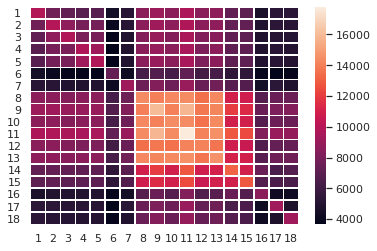

{'營收成長率': 1, '營業毛利成長率': 2, '營業利益成長率': 3, '稅前淨利成長率': 4, '經常淨利成長率': 5, '折舊性FA成長率': 6, '研究發展費': 7, '每股盈餘': 8, 'ROA(C)稅前息前折舊前': 9, 'ROE(A)－稅後': 10, '營業毛利率': 11, '營業利益率': 12, '稅前淨利率': 13, '來自營運之現金流量/營業收入淨額': 14, '來自營運之現金流量/ 繼續營業單位損益': 15, '來自營運現金流量成長率': 16, '應收帳款週轉次數': 17, '存貨週轉率（次）': 18}


In [ ]:
import seaborn as sns
sns.set(font="simhei")
ax = sns.heatmap(df2, linewidth=0.5, annot=False)
plt.show()
print(temp)

In [ ]:
import networkx as nx
import codecs

In [ ]:
data = []
for x in df2.columns:
    for y in range(1, 19):
        c = [x, y, df2[x][y]]
        data.append(c)

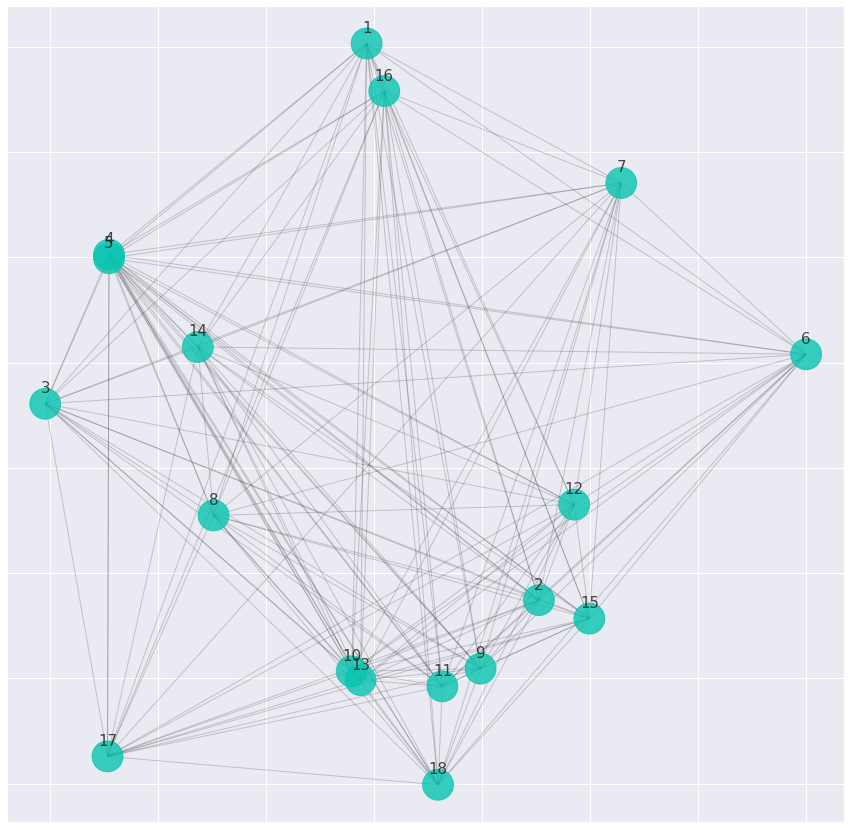

In [ ]:
plt.figure(figsize=(15,15))
g = nx.Graph()
g.add_weighted_edges_from(data)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*50 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
# plt.savefig("remove.png", dpi=100)
plt.show()

In [ ]:
df1

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1
1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0
3,0,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0
4,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18491,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1
18492,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0
18493,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1
18494,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0


## co-occurency matrix




In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210524.csv')

In [ ]:
df.shape

(18496, 130)

In [ ]:
# Drop Unused Columns
df.drop(['最高價', '最低價', '成交量(股)', '交易額(萬)', '開盤價', '收盤價', '漲跌幅(%)', '年/月'], 1, inplace=True)
#(18496,172)

# Sort Columns
first = ['代號', '名稱', '年份', '季']
change_cols = first + [c for c in df.columns if c not in first + ['進場訊號']] + ['進場訊號']
df = df[change_cols]
df.replace({np.inf: 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
# Drop columns that contains too much NaN
c = 0
na_col = []
for x in df.columns[5:-1]:
    zero = len(df[df[x]==0])
    if round(zero/18496, 2) >= 0.8:
        na_col.append(x)
        c += 1
print(na_col)
df.drop(na_col, axis = 1, inplace = True)
#(18496,130)

['聯屬公司已（未）實現銷貨利益', '預期信用減損（損失）利益－營業費用', '其他收益及費損淨額', '預期信用減損（損失）利益', '除列按攤銷後成本衡量金融資產淨損益', '金融資產重分類淨損益', '營業外收入及支出－其他', '停業單位損益', '其他損益調整項－非常項目及累計影響數', '發放特別股股息', '新增投資－CFI', '出售投資－CFI', '現金增（減）資－CFF', '避險之金融資產－流動', '合約資產－流動', '資金貸予他人－流動', '待出售非流動資產', '按攤銷後成本衡量之金融資產－非流動', '避險之金融資產－非流動', '合約資產－非流動', '預付投資款', '使用權資產', '應付商業本票∕承兌匯票', '避險之金融負債－流動', '按攤銷後成本衡量之金融負債－流動', '與待出售非流動資產直接相關之負債', '租賃負債─流動', '特別股負債－流動', '透過損益按公允價值衡量之金融負債－非流動', '避險之金融負債－非流動', '按攤銷後成本衡量之金融負債－非流動', '合約負債－非流動', '特別股負債－非流動', '應付公司債－非流動', '其他長期借款－非流動', '租賃負債－非流動', '負債準備－非流動', '遞延貸項', '特別股股本', '預收股款', '待分配股票股利', '換股權利證書']


In [ ]:
#seperate the data into signal 1 and 0
df_1 = df[df['進場訊號'] == 1]
df_0 = df[df['進場訊號'] == 0]
print(df_1.shape,df_0.shape)

(4785, 130) (13711, 130)


In [ ]:
from tqdm import tqdm_notebook
tqdm_notebook().pandas()


In [ ]:
direct = pd.read_excel(r'/content/drive/MyDrive/ML/方向_2.xlsx')

In [ ]:
direct['remove'] = direct['columns'].apply(lambda x: 1 if x in na_col else 0)
direct = direct[direct['remove'] == 0].drop('remove', axis = 1)
direct.to_csv('direct.csv', index = False)

In [ ]:
#Deal with different types of columns
import math
to_remove = []
dir_s = direct[direct['label'] == 's']['columns'].to_list()
dir_big = direct[direct['label'] == '+']['columns'].to_list()
dir_small = direct[direct['label'] == '-']['columns'].to_list()
#split the dataframe
df_s = df[dir_s]
df_big = df[dir_big]
df_small = df[dir_small]
df_1_s = df_1[dir_s]
df_1_big = df_1[dir_big]
df_1_small = df_1[dir_small]
df_0_s = df_0[dir_s]
df_0_big = df_0[dir_big]
df_0_small = df_0[dir_small]

In [ ]:
#df_s
def xxx(d, a, b):
    if d < 0 and d > b:
        return 1
    elif d > a:
        return 1
    else:
        return 0
for i in df_s.columns:
  if min(df_s[i]) < 0:
    a = [x for x in df_s[i] if x >= 0]
    b = [x for x in df_s[i] if x < 0]
    a75 = np.percentile(a, 75)
    b75 = np.percentile(b, 75)
    df_s[i] = df_s[i].apply(lambda y : xxx(y, a75, b75))
  else:
    a75 = np.percentile(dd[x], 75)
    df_s[i] = df_s[i].apply(lambda y:1 if y > a75 else 0)
#df_1_s
for i in df_s.columns:
  if min(df_1_s[i]) < 0:
    a = [x for x in df_1_s[i] if x >= 0]
    b = [x for x in df_1_s[i] if x < 0]
    a75 = np.percentile(a, 75)
    b75 = np.percentile(b, 75)
    df_1_s[i] = df_1_s[i].apply(lambda y : xxx(y, a75, b75))
  else:
    a75 = np.percentile(dd[x], 75)
    df_1_s[i] = df_1_s[i].apply(lambda y:1 if y > a75 else 0)
#df_0_s
for i in df_0_s.columns:
  if min(df_0_s[i]) < 0:
    a = [x for x in df_0_s[i] if x >= 0]
    b = [x for x in df_0_s[i] if x < 0]
    a75 = np.percentile(a, 75)
    b75 = np.percentile(b, 75)
    df_0_s[i] = df_0_s[i].apply(lambda y : xxx(y, a75, b75))
  else:
    a75 = np.percentile(dd[x], 75)
    df_0_s[i] = df_0_s[i].apply(lambda y:1 if y > a75 else 0)

In [ ]:
#df_big
for i in df_big.columns:
  df_big[i] = df_big[i].progress_apply(lambda x: 1 if x > np.percentile(df_big[i], 75) else 0)
for i in df_1_big.columns:
  df_1_big[i] = df_1_big[i].progress_apply(lambda x: 1 if x > np.percentile(df_1_big[i], 75) else 0)
for i in df_0_big.columns:
  df_0_big[i] = df_0_big[i].progress_apply(lambda x: 1 if x > np.percentile(df_0_big[i], 75) else 0)

In [ ]:
#df_small
for i in df_small.columns:
  df_small[i] = df_small[i].progress_apply(lambda x: 1 if x < np.percentile(df_small[i], 25) else 0)
for i in df_1_small.columns:
  df_1_small[i] = df_1_small[i].progress_apply(lambda x: 1 if x < np.percentile(df_1_small[i], 25) else 0)
for i in df_0_small.columns:
  df_0_small[i] = df_0_small[i].progress_apply(lambda x: 1 if x < np.percentile(df_0_small[i], 25) else 0)

In [ ]:
matrix = pd.concat([df_s, df_big, df_small] ,axis = 1)
matrix_1 = pd.concat([df_1_s,df_1_big,df_1_small], axis = 1)
matrix_0 = pd.concat([df_0_s,df_0_big,df_0_small], axis = 1)

In [ ]:
matrix.to_csv('matrix_all.csv', index=False)
matrix_0.to_csv('matrix_0.csv', index=False)
matrix_1.to_csv('matrix_1.csv', index=False)

In [ ]:
co_matrix = matrix.T.dot(matrix)
co_matrix1 = matrix_1.T.dot(matrix_1)
co_matrix0 = matrix_0.T.dot(matrix_0)

In [ ]:
co_matrix1.to_csv(r'/content/drive/MyDrive/ML/comatrix_1.csv',index = False)
co_matrix0.to_csv(r'/content/drive/MyDrive/ML/conmatrix_0.csv',index = False)

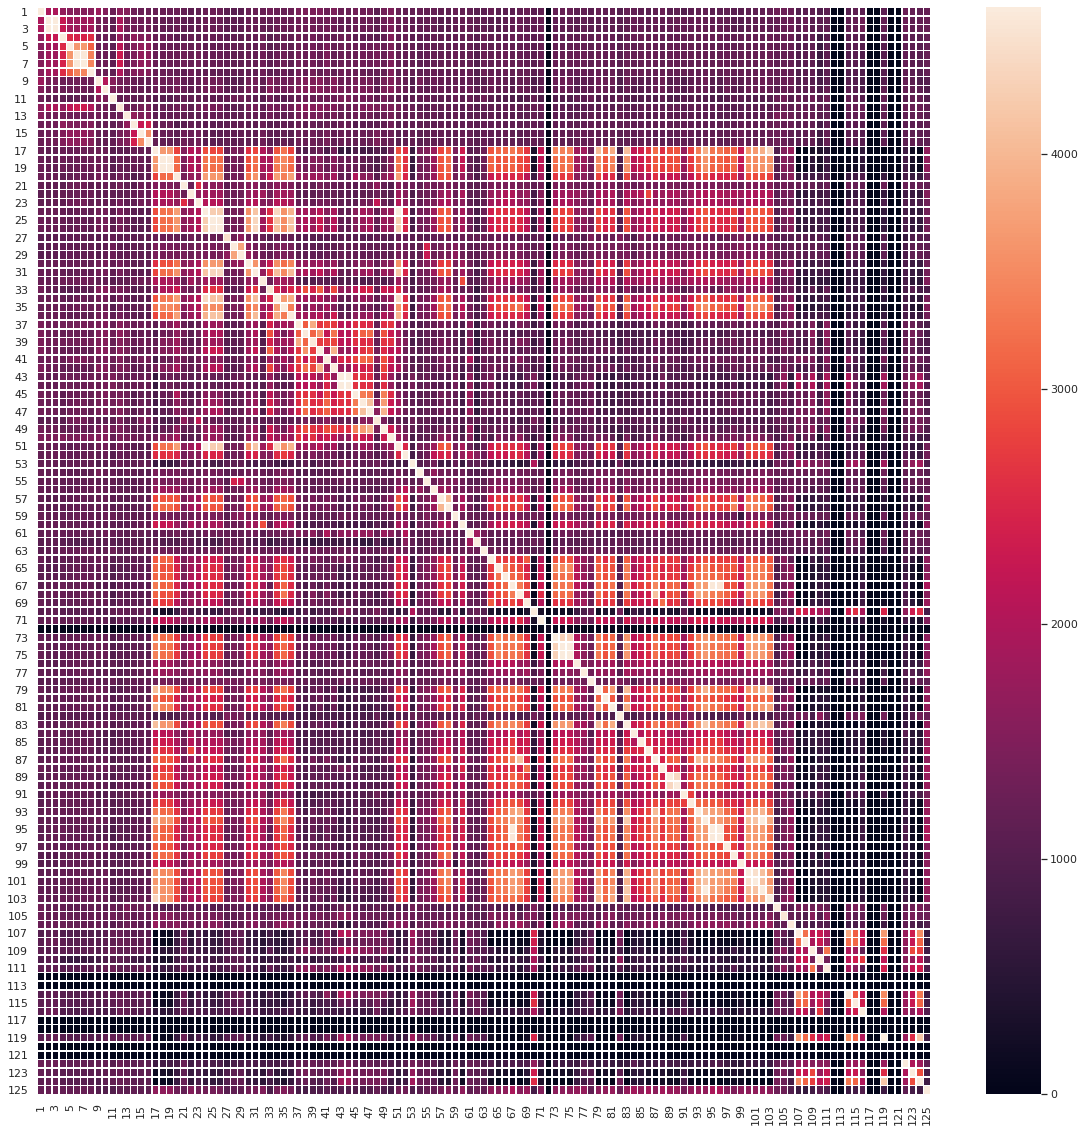

{'營收成長率': 1, '營業毛利成長率': 2, '已實現銷貨毛利成長率': 3, '營業利益成長率': 4, '稅前淨利成長率': 5, '稅後淨利成長率': 6, '經常淨利成長率': 7, '常續淨利成長率': 8, '總資產成長率': 9, '淨值成長率': 10, '折舊性FA成長率': 11, '總資產報酬成長率': 12, '營收變動率': 13, '營業利益變動率': 14, '淨利變動率（單季）': 15, '稅前盈餘變動率': 16, '營業收入淨額': 17, '營業毛利': 18, '已實現銷貨毛利': 19, '營業利益': 20, '其他利益及損失': 21, '採權益法之關聯企業及合資損益之份額': 22, '營業外收入及支出': 23, '稅前淨利': 24, '繼續營業單位損益': 25, '合併總損益': 26, '不重分類至損益之項目－OCI': 27, '後續可能重分類至損益之項目－OCI': 28, '其他綜合損益－OCI': 29, '本期綜合損益總額': 30, '歸屬母公司淨利（損）': 31, '歸屬非控制權益淨利（損）': 32, '每股盈餘': 33, '稅前息前淨利': 34, '稅前息前折舊前淨利': 35, '常續性稅後淨利': 36, 'ROA(C)稅前息前折舊前': 37, 'ROA(A)稅後息前': 38, 'ROA(B)稅後息前折舊前': 39, 'ROE(A)－稅後': 40, '稅前息前折舊前淨利率': 41, 'ROE(B)－常續利益': 42, '營業毛利率': 43, '已實現銷貨毛利率': 44, '營業利益率': 45, '稅前淨利率': 46, '稅後淨利率': 47, '業外收支/營收': 48, '常續利益率－稅後': 49, '貝里比率': 50, '稅前淨利－CFO': 51, '來自營運之現金流量': 52, '投資活動之現金流量': 53, '籌資活動之現金流量': 54, '匯率影響數': 55, '本期產生現金流量': 56, '未分配盈餘': 57, '保留盈餘': 58, '其他權益': 59, '非控制權益': 60, '來自營運之現金流量/營業收入淨額': 61, '來自營運之現金流量/ 繼續營業單位損益': 62, '來自營運現金流量成長率': 63, 

In [ ]:
#draw heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font= 'simhei')

plt.figure(figsize=(20, 20))
ax = sns.heatmap(co_matrix, linewidth=0.5, annot=False)
plt.show()
print(temp)

In [ ]:
matrix_data = []
for x in co_matrix.columns:
    for y in range(1,125):
        c = [x, y, co_matrix[x][y]]
        matrix_data.append(c)

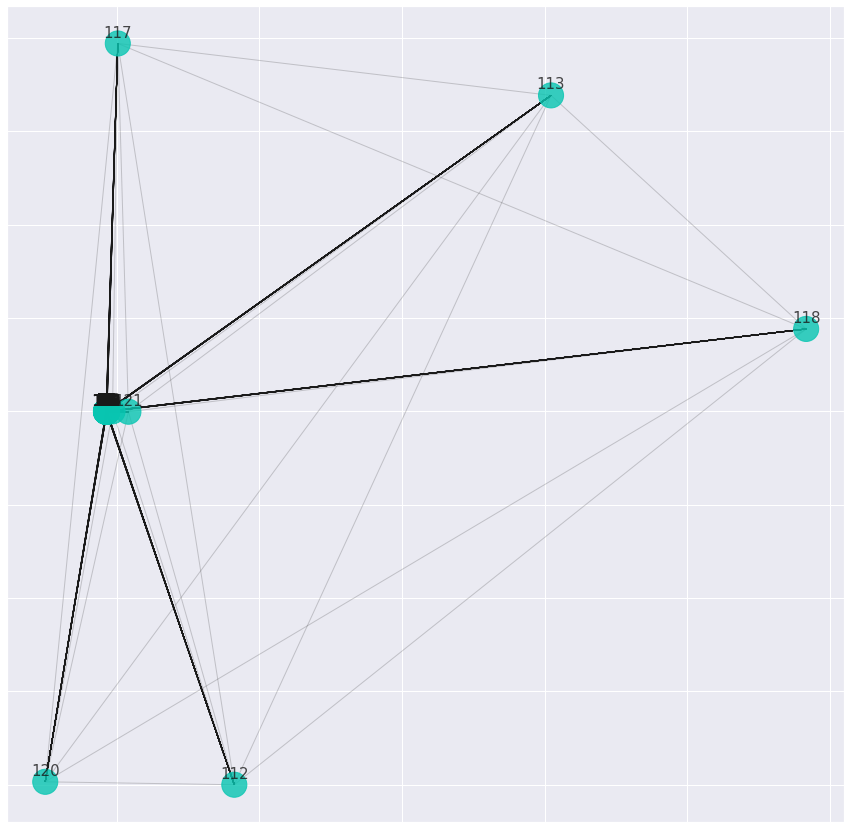

In [ ]:
plt.figure(figsize=(15,15))
g = nx.Graph()
g.add_weighted_edges_from(matrix_data)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*5 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
# plt.savefig("remove.png", dpi=100)
plt.show()

##20210530

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#original_data = pd.read_csv(sys.argv[1]).drop(columns=["label_headers"]).values.flatten()
#condition
comatrix = pd.read_csv(r'/content/drive/MyDrive/ML/comatrix_all.csv')
data =[]
for i in comatrix.columns:
  for j in range(0,125):
    a = comatrix[i][j]
    data.append(a)


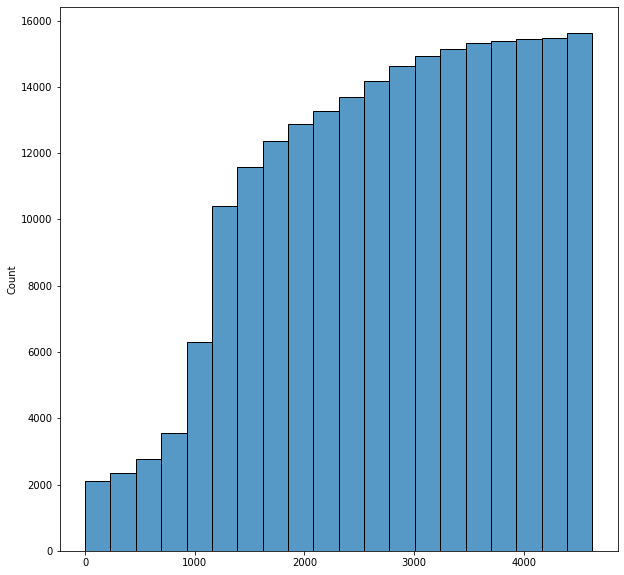

In [ ]:
#draw the hist
plt.figure(figsize=(10, 10))
ax = sns.histplot(data, bins = 20,cumulative=True, stat="count")
plt.show()

<Figure size 720x720 with 0 Axes>

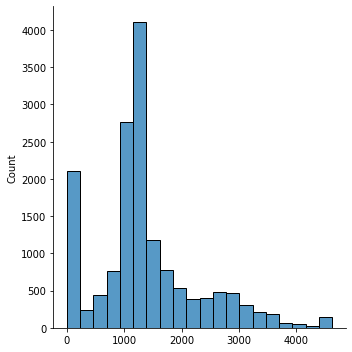

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.displot(data,bins = 20)
plt.show()

In [ ]:
#draw network graph after masking
temp = dict(zip(list(comatrix.columns), list(range(1, len(comatrix.columns)+1))))
comatrix.columns = [temp[x] for x in comatrix.columns if x in list(temp.keys())]

In [ ]:
g1_data =[]
for i in matrix1.columns:
  for j in range(0,125):
    if matrix1[i][j] >= 2500:
      a = [i,j,matrix1[i][j]]
      g1_data.append(a)
    else:
      pass

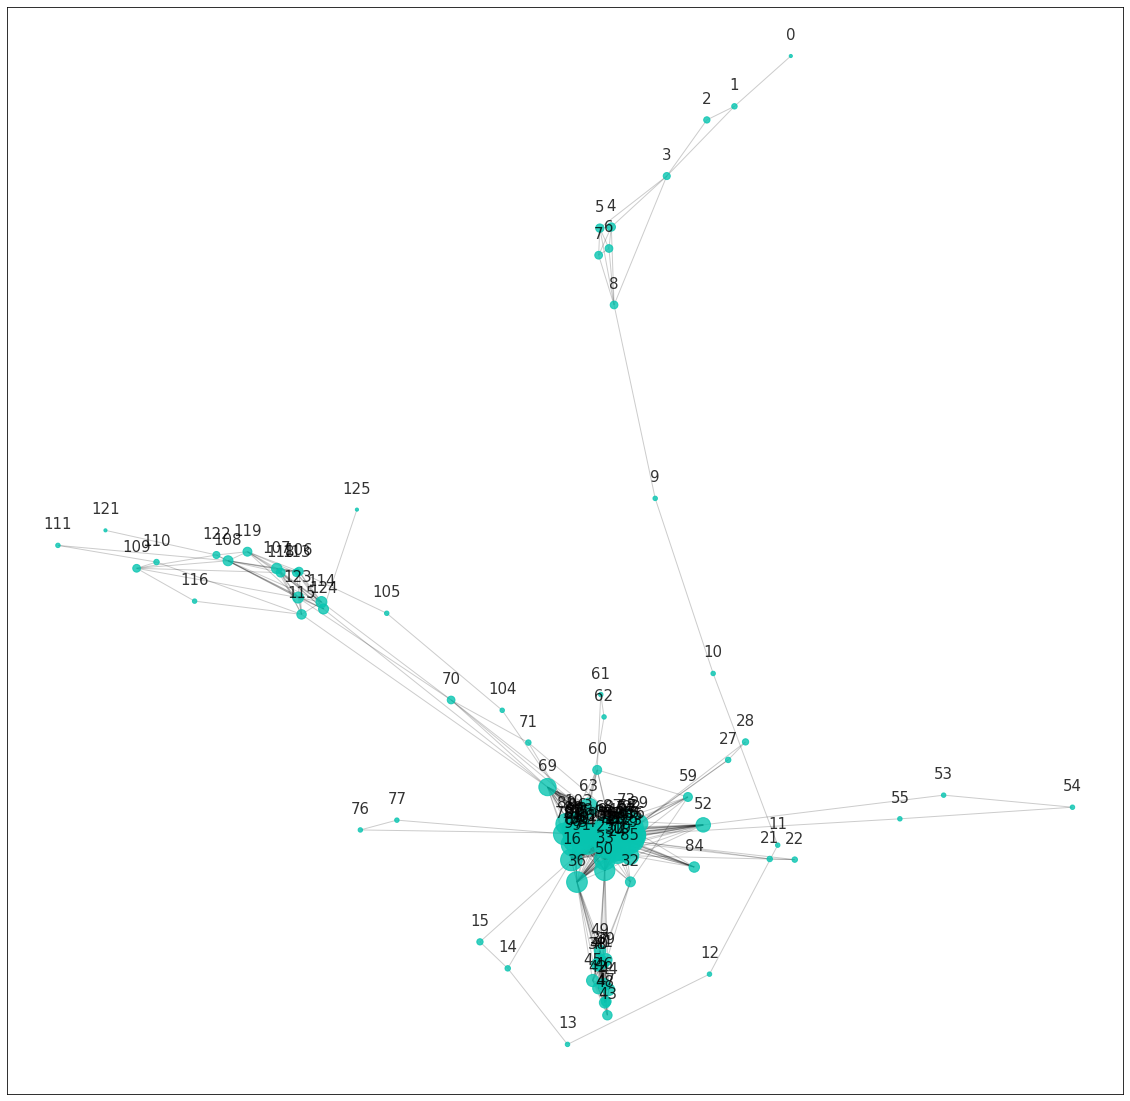

{'營收成長率': 1, '營業毛利成長率': 2, '已實現銷貨毛利成長率': 3, '營業利益成長率': 4, '稅前淨利成長率': 5, '稅後淨利成長率': 6, '經常淨利成長率': 7, '常續淨利成長率': 8, '總資產成長率': 9, '淨值成長率': 10, '折舊性FA成長率': 11, '總資產報酬成長率': 12, '營收變動率': 13, '營業利益變動率': 14, '淨利變動率（單季）': 15, '稅前盈餘變動率': 16, '營業收入淨額': 17, '營業毛利': 18, '已實現銷貨毛利': 19, '營業利益': 20, '其他利益及損失': 21, '採權益法之關聯企業及合資損益之份額': 22, '營業外收入及支出': 23, '稅前淨利': 24, '繼續營業單位損益': 25, '合併總損益': 26, '不重分類至損益之項目－OCI': 27, '後續可能重分類至損益之項目－OCI': 28, '其他綜合損益－OCI': 29, '本期綜合損益總額': 30, '歸屬母公司淨利（損）': 31, '歸屬非控制權益淨利（損）': 32, '每股盈餘': 33, '稅前息前淨利': 34, '稅前息前折舊前淨利': 35, '常續性稅後淨利': 36, 'ROA(C)稅前息前折舊前': 37, 'ROA(A)稅後息前': 38, 'ROA(B)稅後息前折舊前': 39, 'ROE(A)－稅後': 40, '稅前息前折舊前淨利率': 41, 'ROE(B)－常續利益': 42, '營業毛利率': 43, '已實現銷貨毛利率': 44, '營業利益率': 45, '稅前淨利率': 46, '稅後淨利率': 47, '業外收支/營收': 48, '常續利益率－稅後': 49, '貝里比率': 50, '稅前淨利－CFO': 51, '來自營運之現金流量': 52, '投資活動之現金流量': 53, '籌資活動之現金流量': 54, '匯率影響數': 55, '本期產生現金流量': 56, '未分配盈餘': 57, '保留盈餘': 58, '其他權益': 59, '非控制權益': 60, '來自營運之現金流量/營業收入淨額': 61, '來自營運之現金流量/ 繼續營業單位損益': 62, '來自營運現金流量成長率': 63, 

In [ ]:
import networkx as nx
import codecs
plt.figure(figsize=(20,20))
g = nx.Graph()
g.add_weighted_edges_from(g1_data)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*10 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
# plt.savefig("remove.png", dpi=100)
plt.show()
print(temp)

In [ ]:
comatrix_1 = pd.read_csv(r'/content/drive/MyDrive/ML/comatrix_1.csv')
data =[]
for i in comatrix_1.columns:
  for j in range(0,125):
    a = comatrix_1[i][j]
    data.append(a)


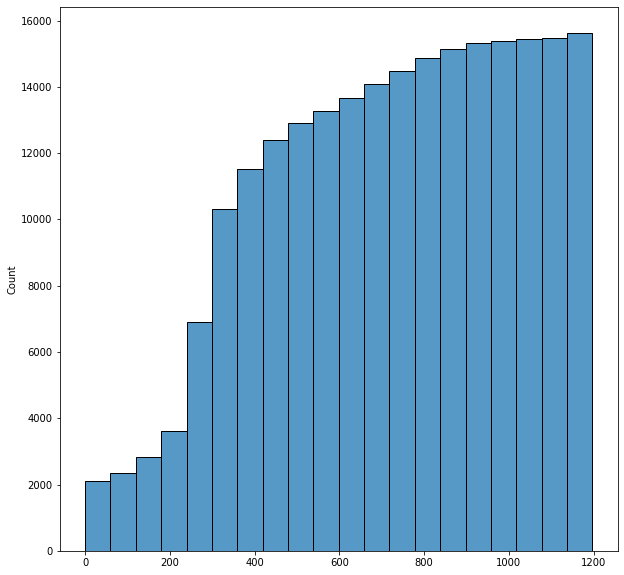

In [ ]:
#draw the hist
plt.figure(figsize=(10, 10))
ax = sns.histplot(data, bins = 20,cumulative=True, stat="count")
plt.show()

<Figure size 720x720 with 0 Axes>

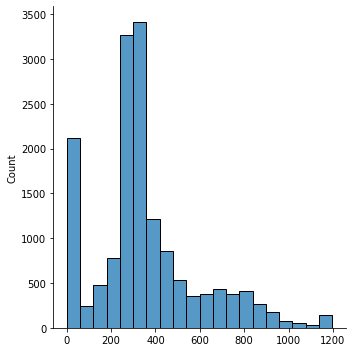

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.displot(data,bins = 20)
plt.show()

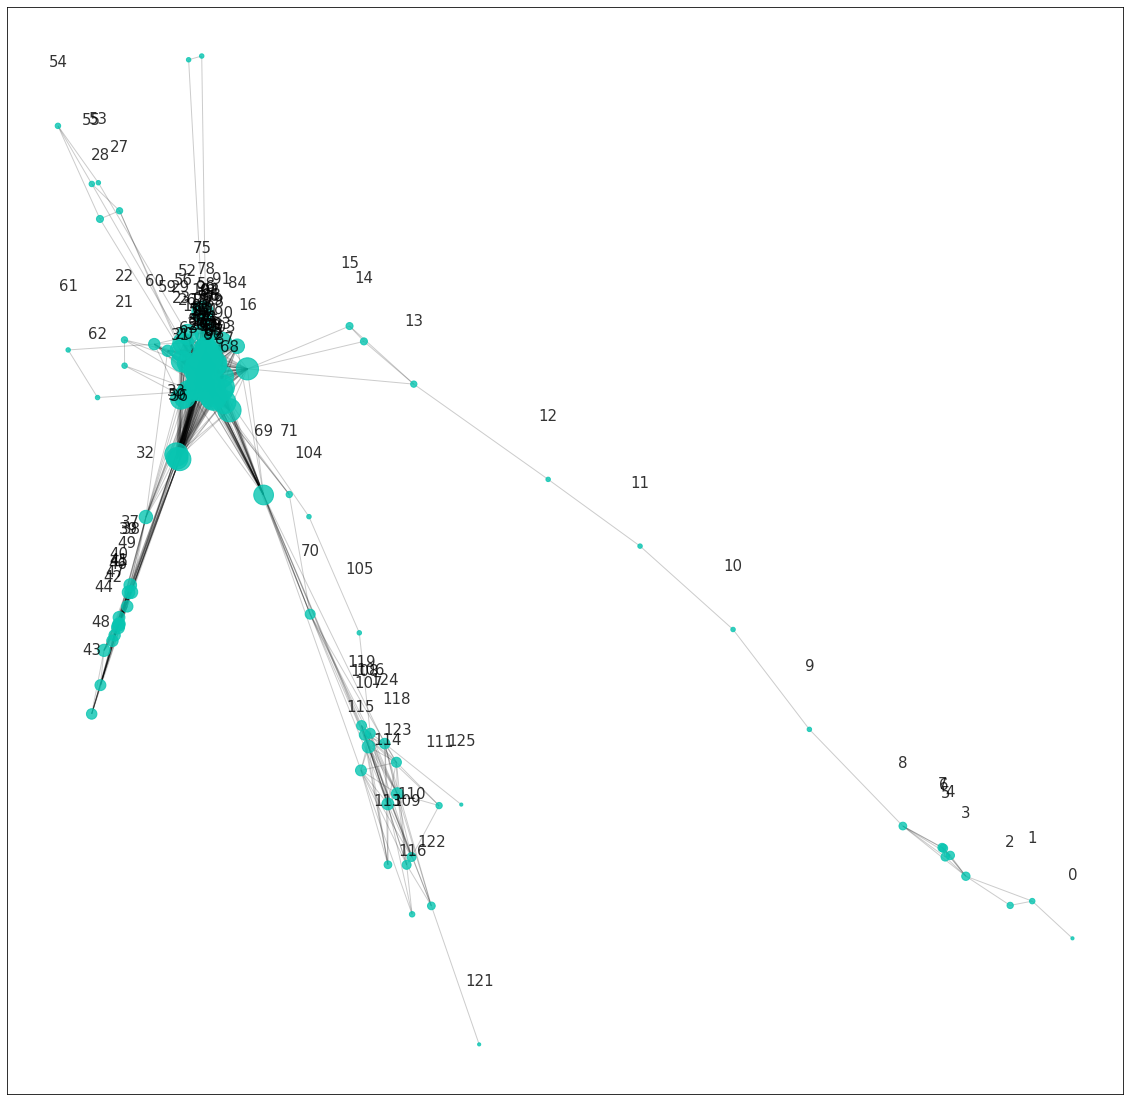

{'營收成長率': 1, '營業毛利成長率': 2, '已實現銷貨毛利成長率': 3, '營業利益成長率': 4, '稅前淨利成長率': 5, '稅後淨利成長率': 6, '經常淨利成長率': 7, '常續淨利成長率': 8, '總資產成長率': 9, '淨值成長率': 10, '折舊性FA成長率': 11, '總資產報酬成長率': 12, '營收變動率': 13, '營業利益變動率': 14, '淨利變動率（單季）': 15, '稅前盈餘變動率': 16, '營業收入淨額': 17, '營業毛利': 18, '已實現銷貨毛利': 19, '營業利益': 20, '其他利益及損失': 21, '採權益法之關聯企業及合資損益之份額': 22, '營業外收入及支出': 23, '稅前淨利': 24, '繼續營業單位損益': 25, '合併總損益': 26, '不重分類至損益之項目－OCI': 27, '後續可能重分類至損益之項目－OCI': 28, '其他綜合損益－OCI': 29, '本期綜合損益總額': 30, '歸屬母公司淨利（損）': 31, '歸屬非控制權益淨利（損）': 32, '每股盈餘': 33, '稅前息前淨利': 34, '稅前息前折舊前淨利': 35, '常續性稅後淨利': 36, 'ROA(C)稅前息前折舊前': 37, 'ROA(A)稅後息前': 38, 'ROA(B)稅後息前折舊前': 39, 'ROE(A)－稅後': 40, '稅前息前折舊前淨利率': 41, 'ROE(B)－常續利益': 42, '營業毛利率': 43, '已實現銷貨毛利率': 44, '營業利益率': 45, '稅前淨利率': 46, '稅後淨利率': 47, '業外收支/營收': 48, '常續利益率－稅後': 49, '貝里比率': 50, '稅前淨利－CFO': 51, '來自營運之現金流量': 52, '投資活動之現金流量': 53, '籌資活動之現金流量': 54, '匯率影響數': 55, '本期產生現金流量': 56, '未分配盈餘': 57, '保留盈餘': 58, '其他權益': 59, '非控制權益': 60, '來自營運之現金流量/營業收入淨額': 61, '來自營運之現金流量/ 繼續營業單位損益': 62, '來自營運現金流量成長率': 63, 

In [ ]:
#draw network graph after masking
temp = dict(zip(list(comatrix_1.columns), list(range(1, len(comatrix_1.columns)+1))))
comatrix_1.columns = [temp[x] for x in comatrix_1.columns if x in list(temp.keys())]
g1_data =[]
for i in comatrix_1.columns:
  for j in range(0,125):
    if comatrix_1[i][j] >= 600:
      a = [i,j,comatrix_1[i][j]]
      g1_data.append(a)
    else:
      pass
plt.figure(figsize=(20,20))
g = nx.Graph()
g.add_weighted_edges_from(g1_data)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*10 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
# plt.savefig("remove.png", dpi=100)
plt.show()
print(temp)

In [ ]:
comatrix_0 = pd.read_csv(r'/content/drive/MyDrive/ML/comatrix_0.csv')
data =[]
for i in comatrix_0.columns:
  for j in range(0,125):
    a = comatrix_0[i][j]
    data.append(a)

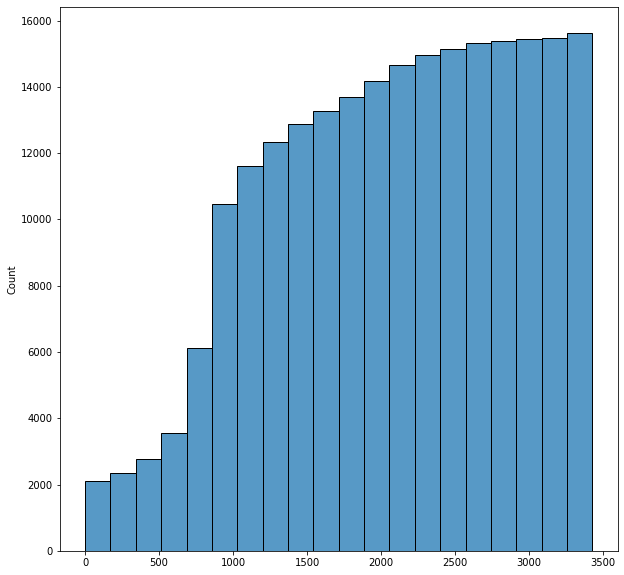

<Figure size 720x720 with 0 Axes>

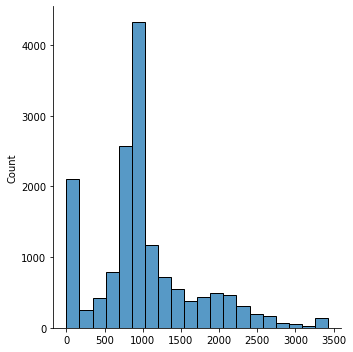

In [ ]:
#draw the hist
plt.figure(figsize=(10, 10))
ax = sns.histplot(data, bins = 20,cumulative=True, stat="count")
plt.show()
plt.figure(figsize=(10,10))
ax = sns.displot(data,bins = 20)
plt.show()

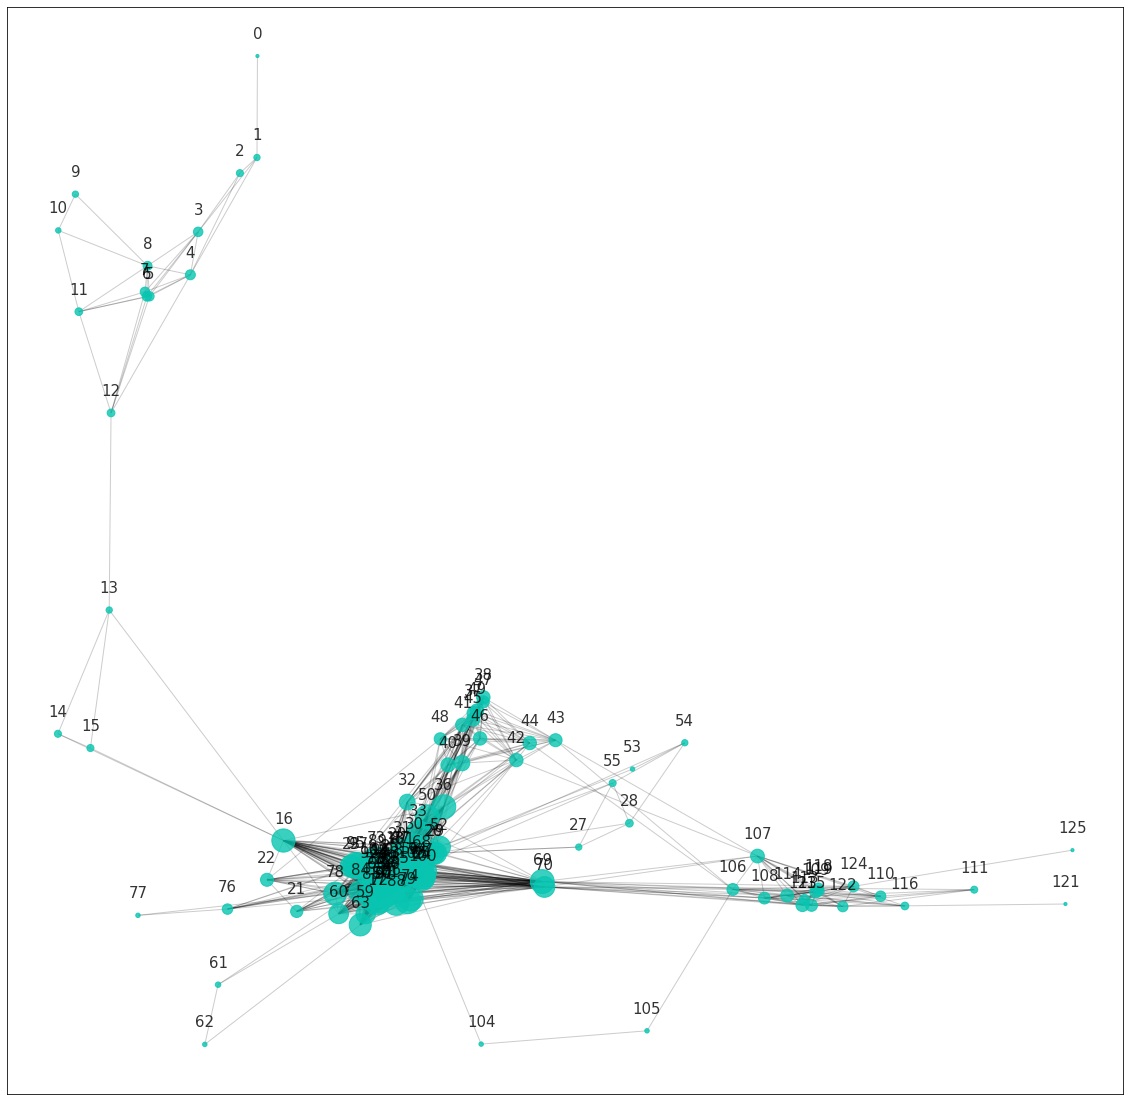

{'營收成長率': 1, '營業毛利成長率': 2, '已實現銷貨毛利成長率': 3, '營業利益成長率': 4, '稅前淨利成長率': 5, '稅後淨利成長率': 6, '經常淨利成長率': 7, '常續淨利成長率': 8, '總資產成長率': 9, '淨值成長率': 10, '折舊性FA成長率': 11, '總資產報酬成長率': 12, '營收變動率': 13, '營業利益變動率': 14, '淨利變動率（單季）': 15, '稅前盈餘變動率': 16, '營業收入淨額': 17, '營業毛利': 18, '已實現銷貨毛利': 19, '營業利益': 20, '其他利益及損失': 21, '採權益法之關聯企業及合資損益之份額': 22, '營業外收入及支出': 23, '稅前淨利': 24, '繼續營業單位損益': 25, '合併總損益': 26, '不重分類至損益之項目－OCI': 27, '後續可能重分類至損益之項目－OCI': 28, '其他綜合損益－OCI': 29, '本期綜合損益總額': 30, '歸屬母公司淨利（損）': 31, '歸屬非控制權益淨利（損）': 32, '每股盈餘': 33, '稅前息前淨利': 34, '稅前息前折舊前淨利': 35, '常續性稅後淨利': 36, 'ROA(C)稅前息前折舊前': 37, 'ROA(A)稅後息前': 38, 'ROA(B)稅後息前折舊前': 39, 'ROE(A)－稅後': 40, '稅前息前折舊前淨利率': 41, 'ROE(B)－常續利益': 42, '營業毛利率': 43, '已實現銷貨毛利率': 44, '營業利益率': 45, '稅前淨利率': 46, '稅後淨利率': 47, '業外收支/營收': 48, '常續利益率－稅後': 49, '貝里比率': 50, '稅前淨利－CFO': 51, '來自營運之現金流量': 52, '投資活動之現金流量': 53, '籌資活動之現金流量': 54, '匯率影響數': 55, '本期產生現金流量': 56, '未分配盈餘': 57, '保留盈餘': 58, '其他權益': 59, '非控制權益': 60, '來自營運之現金流量/營業收入淨額': 61, '來自營運之現金流量/ 繼續營業單位損益': 62, '來自營運現金流量成長率': 63, 

In [ ]:
#draw network graph after masking
temp = dict(zip(list(comatrix_0.columns), list(range(1, len(comatrix_0.columns)+1))))
comatrix_0.columns = [temp[x] for x in comatrix_0.columns if x in list(temp.keys())]
g1_data =[]
for i in comatrix_0.columns:
  for j in range(0,125):
    if comatrix_0[i][j] >= 1500:
      a = [i,j,comatrix_0[i][j]]
      g1_data.append(a)
    else:
      pass
plt.figure(figsize=(20,20))
g = nx.Graph()
g.add_weighted_edges_from(g1_data)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*10 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15, font_family='sans-serif', alpha=0.8)
# plt.savefig("remove.png", dpi=100)
plt.show()
print(temp)

## 關聯規則

In [ ]:
import pandas as pd
matrix_1 = pd.read_csv(r'/content/drive/MyDrive/ML/matrix_all.csv')
from mlxtend.frequent_patterns import apriori
apr_1 = apriori(matrix_1, min_support=0.2,use_colnames=True)

In [ ]:
from mlxtend.frequent_patterns import association_rules
ar_1 = association_rules(apr_1)
ar_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(營業毛利成長率),(已實現銷貨毛利成長率),0.250000,0.249892,0.249351,0.997405,3.991346,0.186878,289.041667
1,(已實現銷貨毛利成長率),(營業毛利成長率),0.249892,0.250000,0.249351,0.997836,3.991346,0.186878,346.650000
2,(經常淨利成長率),(稅後淨利成長率),0.249946,0.250000,0.247567,0.990482,3.961929,0.185081,78.801136
3,(稅後淨利成長率),(經常淨利成長率),0.250000,0.249946,0.247567,0.990268,3.961929,0.185081,77.072222
4,(營業收入淨額),(應收帳款及票據),0.250000,0.250000,0.218101,0.872405,3.489619,0.155601,5.877966
...,...,...,...,...,...,...,...,...,...
1803,(常續性稅後淨利),"(稅前淨利, 合併總損益, 稅前淨利－CFO, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.220480,0.203125,0.812500,3.685140,0.148005,4.157439
1804,(合併總損益),"(稅前淨利, 常續性稅後淨利, 稅前淨利－CFO, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.203558,0.203125,0.812500,3.991501,0.152236,4.247693
1805,(稅前淨利－CFO),"(稅前淨利, 合併總損益, 常續性稅後淨利, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.203125,0.203125,0.812500,4.000000,0.152344,4.250000
1806,(稅前息前淨利),"(稅前淨利, 合併總損益, 常續性稅後淨利, 稅前淨利－CFO, 繼續營業單位損益)",0.250000,0.208856,0.203125,0.812500,3.890241,0.150911,4.219435


In [ ]:
ar_1['length1'] = ar_1['antecedents'].apply(lambda x: len(x))
ar_1['length2'] = ar_1['consequents'].apply(lambda x: len(x))
ar_1.drop(['length1','length2'], inplace = True)
ar_1['length'] = ar_1['length1']+ar_1['length2'] 

In [ ]:
ar_1.drop(['length1','length2'], axis = 1,inplace = True)
ar_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,length
0,(營業毛利成長率),(已實現銷貨毛利成長率),0.250000,0.249892,0.249351,0.997405,3.991346,0.186878,289.041667,2
1,(已實現銷貨毛利成長率),(營業毛利成長率),0.249892,0.250000,0.249351,0.997836,3.991346,0.186878,346.650000,2
2,(經常淨利成長率),(稅後淨利成長率),0.249946,0.250000,0.247567,0.990482,3.961929,0.185081,78.801136,2
3,(稅後淨利成長率),(經常淨利成長率),0.250000,0.249946,0.247567,0.990268,3.961929,0.185081,77.072222,2
4,(營業收入淨額),(應收帳款及票據),0.250000,0.250000,0.218101,0.872405,3.489619,0.155601,5.877966,2
...,...,...,...,...,...,...,...,...,...,...
1803,(常續性稅後淨利),"(稅前淨利, 合併總損益, 稅前淨利－CFO, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.220480,0.203125,0.812500,3.685140,0.148005,4.157439,6
1804,(合併總損益),"(稅前淨利, 常續性稅後淨利, 稅前淨利－CFO, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.203558,0.203125,0.812500,3.991501,0.152236,4.247693,6
1805,(稅前淨利－CFO),"(稅前淨利, 合併總損益, 常續性稅後淨利, 稅前息前淨利, 繼續營業單位損益)",0.250000,0.203125,0.203125,0.812500,4.000000,0.152344,4.250000,6
1806,(稅前息前淨利),"(稅前淨利, 合併總損益, 常續性稅後淨利, 稅前淨利－CFO, 繼續營業單位損益)",0.250000,0.208856,0.203125,0.812500,3.890241,0.150911,4.219435,6


In [ ]:
ar_1.sort_values(by = ['length','confidence','lift'], ascending=False, inplace=True)
ar_1.to_excel('ar_1.xlsx')

In [ ]:
ar_1.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000
mean,0.232161,0.232161,0.211069,0.912720,3.940894,0.157249,inf
std,0.016252,0.016252,0.009530,0.063052,0.266471,0.007941,NaN
min,0.200476,0.200476,0.200043,0.800173,3.206747,0.137922,3.781897
25%,0.220264,0.220264,0.203125,0.856618,3.792877,0.151944,5.443294
50%,0.229617,0.229617,0.208856,0.915874,3.976726,0.156101,9.157455
75%,0.250000,0.250000,0.217074,0.969525,4.087700,0.162091,25.166208
max,0.250054,0.250054,0.250000,1.000000,4.438957,0.187500,inf


In [ ]:
matrix_0 = pd.read_csv(r'/content/drive/MyDrive/ML/matrix_0.csv')
apr_0 = apriori(matrix_0, min_support=0.2,use_colnames=True)
ar_0 = association_rules(apr_0)


,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000
mean,0.231555,0.231555,0.209887,0.910671,3.944366,0.156361,inf
std,0.017330,0.017330,0.009607,0.068071,0.298137,0.008275,NaN
min,0.200131,0.200131,0.200131,0.800467,3.210968,0.138206,3.795130
25%,0.219094,0.219094,0.203413,0.854726,3.792333,0.150934,5.204327
50%,0.229305,0.229305,0.205018,0.915111,3.989593,0.155522,9.078404
75%,0.250018,0.250018,0.214882,0.973899,4.079562,0.161399,29.016186
max,0.250018,0.250018,0.250018,1.000000,4.949799,0.187509,inf


In [ ]:
matrix_all = pd.read_csv(r'/content/drive/MyDrive/ML/matrix_all.csv')
apr_all = apriori(matrix_all, min_support=0.2,use_colnames=True)
ar_all = association_rules(apr_all)


In [ ]:
arlist = [ar_0,ar_all]
for i in arlist:
  i['length1'] = i['antecedents'].apply(lambda x: len(x))
  i['length2'] = i['consequents'].apply(lambda x: len(x))
  i['length'] = i['length1']+i['length2'] 
  i.sort_values(by = ['length','confidence','lift'], ascending=False, inplace=True)
  

In [ ]:
ar_0.drop(['length1','length2'],axis = 1, inplace = True)
ar_0.to_excel('ar_0.xlsx')
ar_all.drop(['length1','length2'],axis = 1, inplace = True)
ar_all.to_excel('ar_all.xlsx')

## PCA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn import model_selection, ensemble, preprocessing, metrics, svm, cluster
import warnings, sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')

In [ ]:
#select columns by the result of association rules
sel_col = ['稅前淨利', '歸屬母公司淨利（損）', '常續性稅後淨利', '合併總損益','稅前淨利－CFO', '繼續營業單位損益','資產總額', '流動資產', '母公司股東權益合計','股東權益總額', '負債及股東權益總額']
df = df[sel_col+['進場訊號']]
print(df.shape)
df.head()

(18496, 12)


,稅前淨利,歸屬母公司淨利（損）,常續性稅後淨利,合併總損益,稅前淨利－CFO,繼續營業單位損益,資產總額,流動資產,母公司股東權益合計,股東權益總額,負債及股東權益總額,進場訊號
0,90511,83139,-22840,83139,90511,83139,1595001,1152989,1043407,1043367,1595001,1
1,316454,212931,204699,230997,316454,230997,42057817,17302727,25172303,25700345,42057817,0
2,1004243,783639,798712,899870,1004243,899870,105679071,45792352,61828295,67625232,105679071,1
3,-44928,-43990,-38682,-44908,-44928,-44908,2289883,977664,853637,902840,2289883,0
4,365693,331718,320268,340418,365693,340418,23916553,16444657,11834028,12042300,23916553,0


In [ ]:
##select columns by the result of association rules
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')
sel_col = ['稅前淨利', '歸屬母公司淨利（損）', '常續性稅後淨利', '合併總損益','稅前淨利－CFO', '繼續營業單位損益','資產總額', '流動資產', '母公司股東權益合計','股東權益總額', '負債及股東權益總額']
df = df[sel_col+['進場訊號']]
y = df.loc[:,'進場訊號']
X = df.drop('進場訊號',axis = 1)
#stadardlization
std = StandardScaler()
std_x = std.fit_transform(X)
# SVM & RF
component = [ i for i in range(1,12)]
component.reverse()
for k in component:
  pca = PCA(n_components=k)
  svc = SVC(gamma = 0.01)
  rf = RandomForestClassifier()
  re_X = pca.fit_transform(std_x)
  X_train, X_test, y_train, y_test = train_test_split(re_X, y, test_size = 0.2)
  svc.fit(X_train,y_train)
  rf.fit(X_train,y_train)
  pred = svc.predict(X_test)
  pred_rf = rf.predict(X_test)
  var = pca.explained_variance_
  percent = pca.explained_variance_ratio_
  acc = accuracy_score(y_test, pred)
  acc_rf = accuracy_score(y_test, pred_rf)
  roc = roc_auc_score(y_test, pred)
  roc_rf = roc_auc_score(y_test, pred_rf)
  cf_matrix = confusion_matrix(y_test,pred)
  cf_matrix_rf = confusion_matrix(y_test,pred_rf)
  print('/PCA/')
  print('Dimension:{}'.format(k))
  print('Varience:',var)
  print('Ratio:',percent)
  print('/SVM/')
  print('ACC:{}'.format(acc))
  print('ROC:{}'.format(roc))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix))
  print('/RF/')
  print('ACC:{}'.format(acc_rf))
  print('ROC:{}'.format(roc_rf))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix_rf))
  print('=================================================')

/PCA/
Dimension:11
Varience: [9.64854235e+00 1.18030128e+00 1.29642965e-01 2.47025717e-02
 1.12149984e-02 3.76160973e-03 1.56382513e-03 6.40056634e-04
 2.25089695e-04 2.93353819e-32 9.23777161e-34]
Ratio: [8.77092791e-01 1.07294316e-01 1.17850869e-02 2.24556692e-03
 1.01949019e-03 3.41946032e-04 1.42158234e-04 5.81838208e-05
 2.04615932e-05 2.66670871e-33 8.39752014e-35]
/SVM/
ACC:0.7356756756756757
ROC:0.5
Confusion Matrix:
[[2722    0]
 [ 978    0]]

/RF/
ACC:0.7289189189189189
ROC:0.5108030604226113
Confusion Matrix:
[[2650   72]
 [ 931   47]]

/PCA/
Dimension:10
Varience: [9.64854235e+00 1.18030128e+00 1.29642965e-01 2.47025717e-02
 1.12149984e-02 3.76160973e-03 1.56382513e-03 6.40056634e-04
 2.25089695e-04 2.93353819e-32]
Ratio: [8.77092791e-01 1.07294316e-01 1.17850869e-02 2.24556692e-03
 1.01949019e-03 3.41946032e-04 1.42158234e-04 5.81838208e-05
 2.04615932e-05 2.66670871e-33]
/SVM/
ACC:0.7418918918918919
ROC:0.5001599429549518
Confusion Matrix:
[[2744    2]
 [ 953    1]]

/RF/

In [ ]:
#Tuning
from sklearn.model_selection import GridSearchCV
parameter = [{'gamma':[1e-4, 1e-3, 0.01, 0.1],
        'C':[1, 10, 100, 1000, 10000]}]
grid = GridSearchCV(SVC(),parameter, cv = 5)
grid.fit(X_train, y_train)
best = grid.best_params_
best

{'C': 1, 'gamma': 0.01}

## RF with all columns

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import warnings, sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')
print(df.shape)
df.head()

(18496, 130)


,代號,名稱,年份,季,營收成長率,營業毛利成長率,已實現銷貨毛利成長率,營業利益成長率,稅前淨利成長率,稅後淨利成長率,經常淨利成長率,常續淨利成長率,總資產成長率,淨值成長率,折舊性FA成長率,總資產報酬成長率,營收變動率,營業利益變動率,淨利變動率（單季）,稅前盈餘變動率,營業收入淨額,營業成本,營業毛利,已實現銷貨毛利,營業費用,研究發展費,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,其他綜合損益－OCI,...,遞延資產合計,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,透過損益按公允價值衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,一年內到期長期負債,流動負債,銀行借款－非流動,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,非控制權益,股東權益總額,負債及股東權益總額,單季營收(千元),單季營收成長,來自營運之現金流量/營業收入淨額,來自營運之現金流量/ 繼續營業單位損益,來自營運現金流量成長率,應收帳款週轉次數,存貨週轉率（次）,進場訊號
0,1471,首利,2020,4,3.55,873.06,873.06,45.97,254.92,250.96,250.96,43.24,26.00,60.83,-46.1019,7.01,-43.91,-325.25,-79.91,-78.89,241949,212333,29616,29616,53461,2314,-23845,185,8795,107566,2005,0,114356,90511,7372,83139,83139,132,-4415,-4283,...,0,16973,55447,442012,1595001,80000,0,0,202854,98639,26,129071,18657,536061,10883,0,0,15573,551634,1504145,1504145,3539,0,0,-534665,-534665,70388,0,1043407,-40,1043367,1595001,241949,0.377110,-0.109416,-0.318419,59.047383,0.80,2.41,1
1,1503,士電,2020,4,10.71,-6.45,-6.45,-13.94,-22.23,-39.65,-39.65,-40.02,3.19,4.16,-0.0697,-0.36,20.88,-45.16,-46.51,-46.98,7262739,6138053,1124686,1124686,845686,166352,279000,9288,10382,5390,11440,33122,37454,316454,85457,230997,230997,198889,69897,268786,...,374933,7385525,7928401,24755090,42057817,2145977,10419,1663954,5848635,1450559,264055,973862,0,12658049,850000,407380,2263326,3699423,16357472,5209722,5209722,2626221,2730986,5136954,8750888,16618828,717532,0,25172303,528042,25700345,42057817,7262361,0.388073,0.105486,3.316558,117.784897,1.24,1.36,0
2,1504,東元,2020,4,3.44,3.16,3.16,30.24,21.68,37.02,37.02,30.38,6.64,9.59,-4.9576,0.30,8.97,21.07,15.30,4.05,12474622,9910318,2564304,2564629,1703907,247603,860722,31038,135040,19954,47791,36318,143521,1004243,104373,899870,899870,-745408,184386,-561022,...,1365301,2850964,10916535,59886719,105679071,2816832,0,1493931,8018643,4902975,490113,406874,302331,19618968,3309400,1656948,2539962,18434871,38053839,19676929,19676929,7386901,7024635,3640779,17271503,27936917,7339258,-511710,61828295,5796937,67625232,105679071,12385855,0.356141,0.190255,2.637443,4.224476,1.25,1.01,1
3,1506,正道,2020,4,-13.63,184.84,184.84,59.16,74.51,73.30,73.30,62.34,-16.10,2.37,-17.2768,4.81,5.88,25.37,22.67,22.51,211845,198022,13823,13823,54570,7977,-40747,103,-832,-3770,3299,3720,-4181,-44928,-20,-44908,-44908,2442,4307,6749,...,119316,0,11972,1312219,2289883,454606,0,0,109720,184011,0,0,77782,865931,384896,15381,100891,521112,1387043,1631618,1631618,139516,0,0,-793236,-793236,-124261,0,853637,49203,902840,2289883,213851,0.031696,0.035989,-0.169769,-85.557050,1.09,0.47,0
4,1507,永大,2020,4,20.18,20.96,20.96,13.12,34.52,55.61,55.61,37.14,10.38,5.40,-2.4472,0.50,6.10,-20.61,-24.82,-36.06,4492021,3433267,1058754,1058754,758439,129078,300315,14744,17090,43946,236,4578,65378,365693,25275,340418,340418,-158423,145462,-12961,...,687835,822667,1275216,7471896,23916553,0,0,6452490,3723544,939780,159658,0,0,11327860,0,259929,3666,546393,11874253,4108200,4108200,279398,3171035,307639,4117021,7595695,-79854,-69411,11834028,208272,12042300,23916553,4472170,0.005277,0.081834,1.079852,-10.728787,1.07,0.59,0


In [ ]:
y = df.loc[:,'進場訊號']
X = df.loc[:,'營收成長率':'存貨週轉率（次）']

In [ ]:
std = StandardScaler()
std_x = std.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(std_x, y, test_size = 0.2, random_state = 42)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
acc = accuracy_score(y_test, rf.predict(X_test))
print(dict(zip(X.columns, rf.feature_importances_.round(3))))
print("ACC:{0:.1%}".format(acc))


{'營收成長率': 0.01, '營業毛利成長率': 0.01, '已實現銷貨毛利成長率': 0.01, '營業利益成長率': 0.01, '稅前淨利成長率': 0.02, '稅後淨利成長率': 0.01, '經常淨利成長率': 0.01, '常續淨利成長率': 0.02, '總資產成長率': 0.01, '淨值成長率': 0.01, '折舊性FA成長率': 0.01, '總資產報酬成長率': 0.01, '營收變動率': 0.01, '營業利益變動率': 0.01, '淨利變動率（單季）': 0.01, '稅前盈餘變動率': 0.01, '營業收入淨額': 0.01, '營業成本': 0.01, '營業毛利': 0.01, '已實現銷貨毛利': 0.01, '營業費用': 0.01, '研究發展費': 0.01, '營業利益': 0.01, '利息收入': 0.01, '其他收入': 0.01, '其他利益及損失': 0.01, '財務成本': 0.01, '採權益法之關聯企業及合資損益之份額': 0.01, '營業外收入及支出': 0.01, '稅前淨利': 0.01, '所得稅費用': 0.01, '繼續營業單位損益': 0.01, '合併總損益': 0.01, '不重分類至損益之項目－OCI': 0.01, '後續可能重分類至損益之項目－OCI': 0.01, '其他綜合損益－OCI': 0.01, '本期綜合損益總額': 0.01, '歸屬母公司淨利（損）': 0.01, '歸屬非控制權益淨利（損）': 0.01, '每股盈餘': 0.01, '加權平均股數': 0.01, '稅前息前淨利': 0.01, '稅前息前折舊前淨利': 0.01, '常續性稅後淨利': 0.01, 'ROA(C)稅前息前折舊前': 0.01, 'ROA(A)稅後息前': 0.01, 'ROA(B)稅後息前折舊前': 0.01, 'ROE(A)－稅後': 0.01, '稅前息前折舊前淨利率': 0.01, 'ROE(B)－常續利益': 0.01, '營業毛利率': 0.01, '已實現銷貨毛利率': 0.01, '營業利益率': 0.01, '稅前淨利率': 0.01, '稅後淨利率': 0.01, '業外收支/營收': 0.01, '常續利益率－稅後': 0.01, '貝里比率

In [ ]:
important = dict(zip(X.columns, rf.feature_importances_.round(4)))
imp = pd.DataFrame(columns=['column','RF_importance'])
imp.head()
imp['column'] = X.columns
imp['RF_importance'] = rf.feature_importances_.round(4)
imp = imp.sort_values(by = 'RF_importance', ascending = False)
imp.head(20)
sel_rf = imp['column'].head(10).to_list()

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')
y = df.loc[:,'進場訊號']
X = df[sel_rf]
std_x = std.fit_transform(X)
component = [i for i in range(1,11)]
component.reverse()
for k in component:
  pca = PCA(n_components=k)
  svc = SVC(gamma = 0.01)
  rf = RandomForestClassifier()
  re_X = pca.fit_transform(std_x)
  X_train, X_test, y_train, y_test = train_test_split(re_X, y, test_size = 0.2)
  svc.fit(X_train,y_train)
  rf.fit(X_train,y_train)
  pred = svc.predict(X_test)
  pred_rf = rf.predict(X_test)
  var = pca.explained_variance_
  percent = pca.explained_variance_ratio_
  acc = accuracy_score(y_test, pred)
  acc_rf = accuracy_score(y_test, pred_rf)
  roc = roc_auc_score(y_test, pred)
  roc_rf = roc_auc_score(y_test, pred_rf)
  cf_matrix = confusion_matrix(y_test,pred)
  cf_matrix_rf = confusion_matrix(y_test,pred_rf)
  print('/PCA/')
  print('Dimension:{}'.format(k))
  print('Varience:',var)
  print('Ratio:',percent)
  print('/SVM/')
  print('ACC:{}'.format(acc))
  print('ROC:{}'.format(roc))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix))
  print('/RF/')
  print('ACC:{}'.format(acc_rf))
  print('ROC:{}'.format(roc_rf))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix_rf))
  print('==================================================')

/PCA/
Dimension:10
Varience: [2.00168996e+00 1.18255079e+00 1.08783173e+00 1.02601645e+00
 1.00008840e+00 9.87976429e-01 9.77989280e-01 9.15858191e-01
 8.20010701e-01 5.28756703e-04]
Ratio: [2.00158174e-01 1.18248686e-01 1.08777291e-01 1.02596098e-01
 1.00003433e-01 9.87923014e-02 9.77936405e-02 9.15808675e-02
 8.19966367e-02 5.28728116e-05]
/SVM/
ACC:0.7494594594594595
ROC:0.5014341991229321
Confusion Matrix:
[[2770    1]
 [ 926    3]]

/RF/
ACC:0.7283783783783784
ROC:0.513835049231643
Confusion Matrix:
[[2618  153]
 [ 852   77]]

/PCA/
Dimension:9
Varience: [2.00168996 1.18255079 1.08783173 1.02601645 1.0000884  0.98797643
 0.97798928 0.91585819 0.8200107 ]
Ratio: [0.20015817 0.11824869 0.10877729 0.1025961  0.10000343 0.0987923
 0.09779364 0.09158087 0.08199664]
/SVM/
ACC:0.7429729729729729
ROC:0.49981818181818183
Confusion Matrix:
[[2749    1]
 [ 950    0]]

/RF/
ACC:0.7154054054054054
ROC:0.5133110047846889
Confusion Matrix:
[[2554  196]
 [ 857   93]]

/PCA/
Dimension:8
Varience: 

## SMOTE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings, sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')
print(df.shape)
df.head()

(18496, 130)


,代號,名稱,年份,季,營收成長率,營業毛利成長率,已實現銷貨毛利成長率,營業利益成長率,稅前淨利成長率,稅後淨利成長率,經常淨利成長率,常續淨利成長率,總資產成長率,淨值成長率,折舊性FA成長率,總資產報酬成長率,營收變動率,營業利益變動率,淨利變動率（單季）,稅前盈餘變動率,營業收入淨額,營業成本,營業毛利,已實現銷貨毛利,營業費用,研究發展費,營業利益,利息收入,其他收入,其他利益及損失,財務成本,採權益法之關聯企業及合資損益之份額,營業外收入及支出,稅前淨利,所得稅費用,繼續營業單位損益,合併總損益,不重分類至損益之項目－OCI,後續可能重分類至損益之項目－OCI,其他綜合損益－OCI,...,遞延資產合計,投資性不動產淨額,其他非流動資產,非流動資產,資產總額,短期借款,透過損益按公允價值衡量之金融負債－流動,合約負債－流動,應付帳款及票據,其他應付款,當期所得稅負債,負債準備－流動,一年內到期長期負債,流動負債,銀行借款－非流動,應計退休金負債,遞延所得稅,非流動負債,負債總額,普通股股本,股本,資本公積合計,法定盈餘公積,特別盈餘公積,未分配盈餘,保留盈餘,其他權益,庫藏股票帳面值,母公司股東權益合計,非控制權益,股東權益總額,負債及股東權益總額,單季營收(千元),單季營收成長,來自營運之現金流量/營業收入淨額,來自營運之現金流量/ 繼續營業單位損益,來自營運現金流量成長率,應收帳款週轉次數,存貨週轉率（次）,進場訊號
0,1471,首利,2020,4,3.55,873.06,873.06,45.97,254.92,250.96,250.96,43.24,26.00,60.83,-46.1019,7.01,-43.91,-325.25,-79.91,-78.89,241949,212333,29616,29616,53461,2314,-23845,185,8795,107566,2005,0,114356,90511,7372,83139,83139,132,-4415,-4283,...,0,16973,55447,442012,1595001,80000,0,0,202854,98639,26,129071,18657,536061,10883,0,0,15573,551634,1504145,1504145,3539,0,0,-534665,-534665,70388,0,1043407,-40,1043367,1595001,241949,0.377110,-0.109416,-0.318419,59.047383,0.80,2.41,1
1,1503,士電,2020,4,10.71,-6.45,-6.45,-13.94,-22.23,-39.65,-39.65,-40.02,3.19,4.16,-0.0697,-0.36,20.88,-45.16,-46.51,-46.98,7262739,6138053,1124686,1124686,845686,166352,279000,9288,10382,5390,11440,33122,37454,316454,85457,230997,230997,198889,69897,268786,...,374933,7385525,7928401,24755090,42057817,2145977,10419,1663954,5848635,1450559,264055,973862,0,12658049,850000,407380,2263326,3699423,16357472,5209722,5209722,2626221,2730986,5136954,8750888,16618828,717532,0,25172303,528042,25700345,42057817,7262361,0.388073,0.105486,3.316558,117.784897,1.24,1.36,0
2,1504,東元,2020,4,3.44,3.16,3.16,30.24,21.68,37.02,37.02,30.38,6.64,9.59,-4.9576,0.30,8.97,21.07,15.30,4.05,12474622,9910318,2564304,2564629,1703907,247603,860722,31038,135040,19954,47791,36318,143521,1004243,104373,899870,899870,-745408,184386,-561022,...,1365301,2850964,10916535,59886719,105679071,2816832,0,1493931,8018643,4902975,490113,406874,302331,19618968,3309400,1656948,2539962,18434871,38053839,19676929,19676929,7386901,7024635,3640779,17271503,27936917,7339258,-511710,61828295,5796937,67625232,105679071,12385855,0.356141,0.190255,2.637443,4.224476,1.25,1.01,1
3,1506,正道,2020,4,-13.63,184.84,184.84,59.16,74.51,73.30,73.30,62.34,-16.10,2.37,-17.2768,4.81,5.88,25.37,22.67,22.51,211845,198022,13823,13823,54570,7977,-40747,103,-832,-3770,3299,3720,-4181,-44928,-20,-44908,-44908,2442,4307,6749,...,119316,0,11972,1312219,2289883,454606,0,0,109720,184011,0,0,77782,865931,384896,15381,100891,521112,1387043,1631618,1631618,139516,0,0,-793236,-793236,-124261,0,853637,49203,902840,2289883,213851,0.031696,0.035989,-0.169769,-85.557050,1.09,0.47,0
4,1507,永大,2020,4,20.18,20.96,20.96,13.12,34.52,55.61,55.61,37.14,10.38,5.40,-2.4472,0.50,6.10,-20.61,-24.82,-36.06,4492021,3433267,1058754,1058754,758439,129078,300315,14744,17090,43946,236,4578,65378,365693,25275,340418,340418,-158423,145462,-12961,...,687835,822667,1275216,7471896,23916553,0,0,6452490,3723544,939780,159658,0,0,11327860,0,259929,3666,546393,11874253,4108200,4108200,279398,3171035,307639,4117021,7595695,-79854,-69411,11834028,208272,12042300,23916553,4472170,0.005277,0.081834,1.079852,-10.728787,1.07,0.59,0


In [ ]:
#RF all columns
y = df.loc[:,'進場訊號']
X = df.loc[:,'營收成長率': '存貨週轉率（次）']
X_res, Y_res = SMOTE(random_state = 42).fit_resample(X, y)
std = StandardScaler()
rf = RandomForestClassifier()
std_x = std.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(std_x, Y_res, test_size = 0.2, random_state = 42, stratify = Y_res)
rf.fit(X_train, y_train)
acc = accuracy_score(y_test, rf.predict(X_test))
imp = pd.DataFrame(columns =['column','importance'])
imp['column'] = X.columns
imp['importance'] = rf.feature_importances_.round(4)
imp = imp.sort_values(by = 'importance', ascending = False)
print('ACC:{0:.3}'.format(acc))
imp.head(20)




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ACC:0.804


,column,importance
4,稅前淨利成長率,0.0244
33,不重分類至損益之項目－OCI,0.0218
5,稅後淨利成長率,0.0189
6,經常淨利成長率,0.0185
7,常續淨利成長率,0.0171
3,營業利益成長率,0.0142
1,營業毛利成長率,0.0133
11,總資產報酬成長率,0.0128
119,單季營收成長,0.0126
2,已實現銷貨毛利成長率,0.0125


In [ ]:
from xgboost.sklearn import XGBClassifier
y = df.loc[:,'進場訊號']
X = df.loc[:,'營收成長率': '存貨週轉率（次）']
X_res, Y_res = SMOTE(random_state = 42).fit_resample(X, y)
std = StandardScaler()
xgb = XGBClassifier()
std_x = std.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(std_x, Y_res, test_size = 0.2, random_state = 42, stratify = Y_res)
xgb.fit(X_train, y_train)
acc = accuracy_score(y_test, xgb.predict(X_test))
imp = pd.DataFrame(columns =['column','importance'])
imp['column'] = X.columns
imp['importance'] = xgb.feature_importances_.round(4)
imp = imp.sort_values(by = 'importance', ascending = False)
print('ACC:{0:.3}'.format(acc))
imp.head(20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ACC:0.717


,column,importance
4,稅前淨利成長率,0.1129
7,常續淨利成長率,0.0480
33,不重分類至損益之項目－OCI,0.0289
116,股東權益總額,0.0182
15,稅前盈餘變動率,0.0173
5,稅後淨利成長率,0.0164
109,特別盈餘公積,0.0156
3,營業利益成長率,0.0155
93,合約負債－流動,0.0155
50,營業毛利率,0.0141


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/ML/overall_20210531.csv')
y = df.loc[:,'進場訊號']
X = df[sel_rf]
X_res, Y_res = SMOTE(random_state = 42).fit_resample(X, y)
std_x = std.fit_transform(X_res)
component = [i for i in range(1,11)]
component.reverse()
for k in component:
  #Preparation
  pca = PCA(n_components=k)
  svc = SVC(gamma = 0.01)
  rf = RandomForestClassifier()
  re_X = pca.fit_transform(std_x)
  X_train, X_test, y_train, y_test = train_test_split(re_X, Y_res, test_size = 0.2)
  svc.fit(X_train,y_train)
  rf.fit(X_train,y_train)
  pred = svc.predict(X_test)
  pred_rf = rf.predict(X_test)
  var = pca.explained_variance_
  percent = pca.explained_variance_ratio_
  acc = accuracy_score(y_test, pred)
  acc_rf = accuracy_score(y_test, pred_rf)
  roc = roc_auc_score(y_test, pred)
  roc_rf = roc_auc_score(y_test, pred_rf)
  cf_matrix = confusion_matrix(y_test,pred)
  cf_matrix_rf = confusion_matrix(y_test,pred_rf)
  print('/PCA/')
  print('Dimension:{}'.format(k))
  print('Varience:',var)
  print('Ratio:',percent)
  print('/SVM/')
  print('ACC:{}'.format(acc))
  print('ROC:{}'.format(roc))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix))
  print('/RF/')
  print('ACC:{}'.format(acc_rf))
  print('ROC:{}'.format(roc_rf))
  print('Confusion Matrix:\n{}\n'.format(cf_matrix_rf))
  print('==================================================')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/PCA/
Dimension:10
Varience: [2.00314126e+00 1.24412437e+00 1.18093212e+00 1.02856607e+00
 9.99731405e-01 9.87748666e-01 9.77860277e-01 8.21207827e-01
 7.56835074e-01 2.17623465e-04]
Ratio: [2.00306821e-01 1.24407900e-01 1.18088905e-01 1.02852856e-01
 9.99694948e-02 9.87712645e-02 9.77824617e-02 8.21177880e-02
 7.56807474e-02 2.17615529e-05]
/SVM/
ACC:0.5881494986326344
ROC:0.5878761685337145
Confusion Matrix:
[[1735 1026]
 [1233 1491]]

/RF/
ACC:0.6528714676390155
ROC:0.6530327761175296
Confusion Matrix:
[[1737 1024]
 [ 880 1844]]

/PCA/
Dimension:9
Varience: [2.00314126 1.24412437 1.18093212 1.02856607 0.99973141 0.98774867
 0.97786028 0.82120783 0.75683507]
Ratio: [0.20030682 0.1244079  0.11808891 0.10285286 0.09996949 0.09877126
 0.09778246 0.08211779 0.07568075]
/SVM/
ACC:0.5897903372835005
ROC:0.5912653166742601
Confusion Matrix:
[[1875  828]
 [1422 1360]]

/RF/
ACC:0.6552415679124886
ROC:0.6548102156641993
Confusion Matrix:
[[1689 1014]
 [ 877 1905]]

/PCA/
Dimension:8
Varience: